In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Import swyft
import swyft
DEVICE = 'cpu'

N = 3

In [4]:
def ptrans(u):
    return u*2 - 1

pt = swyft.PriorTransform(ptrans, N)
prior = swyft.Prior(pt)

In [5]:
def simulator(v):
    "Line simulator"
    mu = v
    return dict(x=mu)

In [6]:
def noise(obs, params = None, sigma=0.1):
    mu = obs['x']
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return dict(x=x)

In [7]:
v0 = np.linspace(-0.5, 0.5, N)

In [8]:
obs0 = noise(simulator(v0))

In [9]:
cache = swyft.MemoryCache(N, obs_shapes = {'x': (N,)})

In [10]:
cache.grow(prior, 1000)
cache.simulate(simulator)

Simulate: 100%|██████████| 992/992 [00:02<00:00, 363.51it/s]


In [11]:
indices = cache.sample(prior, 1000)
points = swyft.Points(cache, pt, indices, noise)

In [12]:
re = swyft.RatioCollection(range(N), device=DEVICE)
re.train(points)

In [13]:
cb = swyft.Bound.from_RatioCollection(re, obs0, prior.bound, th = -7)
cb.volume

0.12101008995496433

In [14]:
samples = swyft.PosteriorCollection(re, prior).sample(obs0, 1000)

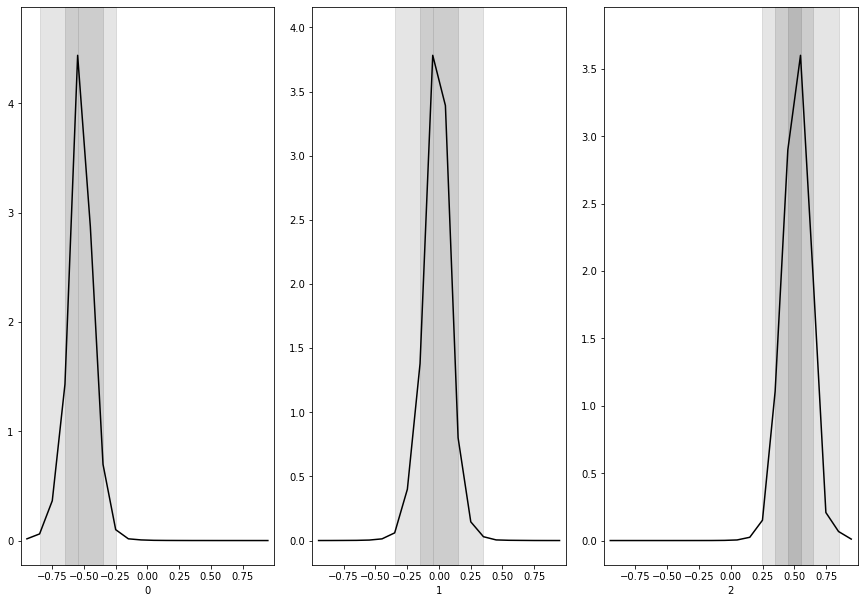

In [15]:
swyft.plot1d(samples, range(N), bins = 20)

In [16]:
prior2 = swyft.BoundedPrior(pt, cb)

In [21]:
cache.grow(prior2, 1000)
cache.simulate(simulator)

Simulate: 100%|██████████| 701/701 [00:01<00:00, 378.37it/s]


In [22]:
indices2 = cache.sample(prior2, 1000)
points2 = swyft.Points(cache, pt, indices2, noise)
z = np.array([points2[i]['par'] for i in range(200)])

(array([24., 26., 19., 19., 15., 14., 24., 19., 17., 23.]),
 array([0.5196189 , 0.56711126, 0.61460362, 0.66209598, 0.70958833,
        0.75708069, 0.80457305, 0.85206541, 0.89955777, 0.94705013,
        0.99454249]),
 <a list of 10 Patch objects>)

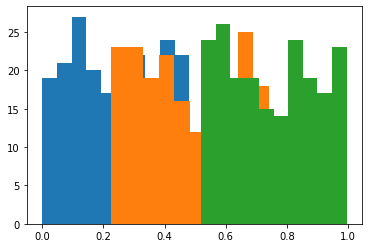

In [25]:
plt.hist(z[:,0])
plt.hist(z[:,1])
plt.hist(z[:,2])

In [26]:
re2 = swyft.RatioCollection(range(N), device=DEVICE)
re2.train(points2)

In [36]:
samples2 = swyft.PosteriorCollection(re2, prior2).sample(obs0, 4000)

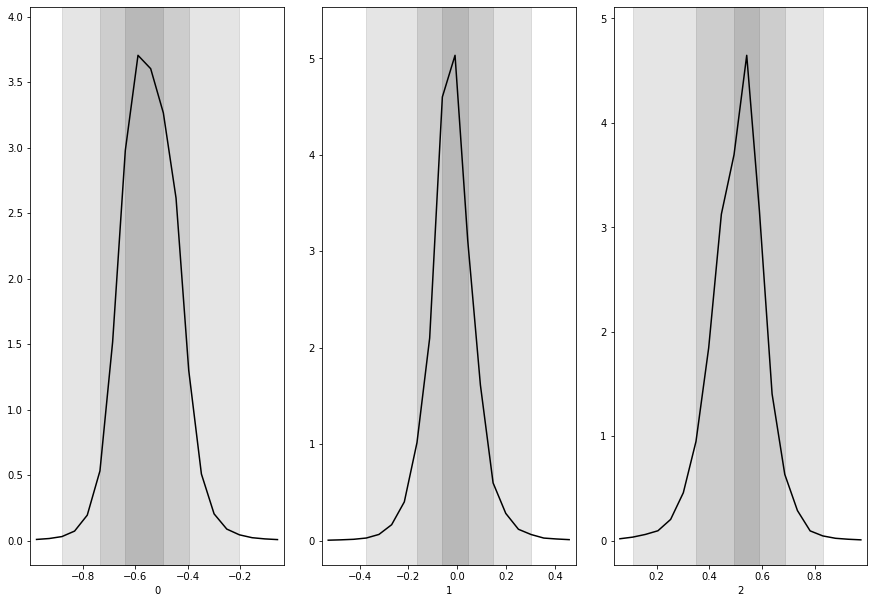

In [37]:
swyft.plot1d(samples2, range(N), bins = 20)

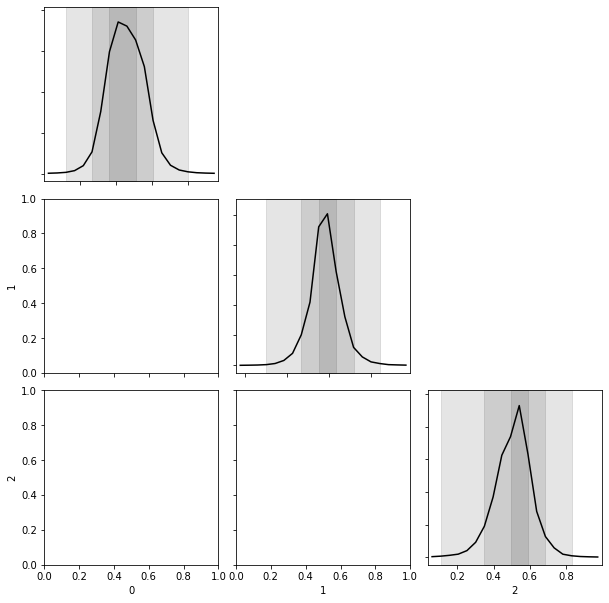

In [43]:
swyft.corner(samples2, range(N), bins = 20)